Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:

Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

In [1]:
import sys
sys.path.append('../')

In [2]:
from utils import load_data

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gmean
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = load_data('../data/competition/train.csv', info=False)
test = load_data('../data/competition/test.csv', info=False)

profile = load_data('../data/competition/client_profile.csv', info=False)

(110093, 3)
(165141, 2)
(250000, 24)


In [4]:
train = train.merge(profile, on='APPLICATION_NUMBER', how='left')
test = test.merge(profile, on='APPLICATION_NUMBER', how='left')

print(train.shape, test.shape)

(110093, 26) (165141, 25)


In [5]:
trash_features = [col for col, val in (train.dtypes == 'object').items() if val]
trash_features

['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS']

# 1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [6]:
def lgbm_cross_valid(X, y, params, n_splits=5, cat_features='auto'):
    
    estimators, fold_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    
    for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_splits).split(X, y)):
        
        Xtrain, Xvalid = X.loc[train_idx], X.loc[valid_idx]
        ytrain, yvalid = y[train_idx], y[valid_idx]
        
        model = lgbm.LGBMClassifier(**params)
        model.fit(
            Xtrain, ytrain,
            eval_set=[(Xvalid, yvalid)],
            verbose=50,
            early_stopping_rounds=50,
            categorical_feature=cat_features
        )
        
        oof_preds[valid_idx] = model.predict_proba(Xvalid)[:, 1]
        scores = roc_auc_score(yvalid, oof_preds[valid_idx])
        scores = round(scores, 4)
        
        print(f"Fold {i+1}, Valid score = {scores}\n")
        
        fold_scores.append(scores)
        estimators.append(model)
        
    print(f"\nScore by each fold: {fold_scores}")
    return estimators, oof_preds

def xgb_cross_valid(X, y, params, n_splits=5):
    
    estimators, fold_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    
    for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_splits).split(X, y)):
        
        Xtrain, Xvalid = X.loc[train_idx], X.loc[valid_idx]
        ytrain, yvalid = y[train_idx], y[valid_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            Xtrain, ytrain,
            eval_set=[(Xvalid, yvalid)],
            
            early_stopping_rounds=50,
            verbose=50
        )
        
        oof_preds[valid_idx] = model.predict_proba(Xvalid)[:, 1]
        scores = roc_auc_score(yvalid, oof_preds[valid_idx])
        scores = round(scores, 4)
        
        print(f"Fold {i+1}, Valid score = {scores}\n")
        
        fold_scores.append(scores)
        estimators.append(model)
        
    print(f"\nScore by each fold: {fold_scores}")
    return estimators, oof_preds

In [7]:
Xytrain = train.drop(trash_features, axis=1)

X, y = Xytrain.drop('TARGET', axis=1), Xytrain['TARGET']

lgbm_params = {
    'device_type': 'gpu',
    'objective': 'binary',
    'metric': 'auc',
    
    'learning_rate': 0.1,
    'num_iterations': 1000
}

lgbm_models, lgbm_oof_preds = lgbm_cross_valid(
    X, y, 
    params=lgbm_params
)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.708311
[100]	valid_0's auc: 0.707301
Early stopping, best iteration is:
[60]	valid_0's auc: 0.710311
Fold 1, Valid score = 0.7103

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.705126
Early stopping, best iteration is:
[39]	valid_0's auc: 0.705332
Fold 2, Valid score = 0.7053

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.712224
Early stopping, best iteration is:
[38]	valid_0's auc: 0.713618
Fold 3, Valid score = 0.7136

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.708265
[100]	valid_0's auc: 0.707003
Early stopping, best iteration is:
[61]	valid_0's auc: 0.709314
Fold 4, Valid score = 0.7093

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.716492
Early stopping, best iteration is:
[29]	valid_0's auc: 0.719459
Fold 5, Valid score = 0.7195


Score by each fold:

In [8]:
xgb_params = {
    'tree_method': 'gpu_hist',
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'max_depth': 5,
    'n_estimators':1000,
    'learning_rate': 0.1
}

xgb_models, xgb_oof_preds = xgb_cross_valid(
    X, y,
    params=xgb_params
)

[0]	validation_0-auc:0.67988
[50]	validation_0-auc:0.70560
[100]	validation_0-auc:0.70767
[128]	validation_0-auc:0.70834
Fold 1, Valid score = 0.7098

[0]	validation_0-auc:0.67171
[50]	validation_0-auc:0.70556
[100]	validation_0-auc:0.70703
[111]	validation_0-auc:0.70641
Fold 2, Valid score = 0.7077

[0]	validation_0-auc:0.69517
[50]	validation_0-auc:0.71454
[100]	validation_0-auc:0.71525
[124]	validation_0-auc:0.71440
Fold 3, Valid score = 0.7171

[0]	validation_0-auc:0.66963
[50]	validation_0-auc:0.70452
[100]	validation_0-auc:0.70899
[150]	validation_0-auc:0.70812
[167]	validation_0-auc:0.70760
Fold 4, Valid score = 0.7093

[0]	validation_0-auc:0.69048
[50]	validation_0-auc:0.71794
[100]	validation_0-auc:0.71839
[129]	validation_0-auc:0.71855
Fold 5, Valid score = 0.7191


Score by each fold: [0.7098, 0.7077, 0.7171, 0.7093, 0.7191]


In [9]:
%%time
def cross_valid_prediction(df, estimators):
    
    result = 0
    for estimator in estimators:
        result += estimator.predict_proba(df)[:, 1]
    
    return result / len(estimators)

lgbm_test_preds = cross_valid_prediction(test.drop(trash_features, axis=1), lgbm_models)
xgb_test_preds = cross_valid_prediction(test.drop(trash_features, axis=1), xgb_models)

Wall time: 2.43 s


<AxesSubplot:title={'center':'test corr'}>

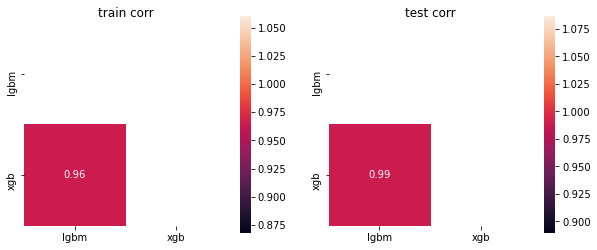

In [10]:
def get_corr(name_preds):
    
    oof_scores = pd.DataFrame(name_preds)
    oof_corr = oof_scores.corr()
    mask = np.zeros_like(oof_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    return oof_scores, oof_corr, mask

oof_scores, oof_corr_train, mask_train = get_corr({'lgbm': lgbm_oof_preds, 'xgb': xgb_oof_preds})
scores, corr_test, mask_test = get_corr({'lgbm': lgbm_test_preds, 'xgb': xgb_test_preds})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('train corr')
sns.heatmap(oof_corr_train, mask=mask_train, annot=True, square=True, ax=ax[0])

ax[1].set_title('test corr')
sns.heatmap(corr_test, mask=mask_test, annot=True, square=True, ax=ax[1])

# 2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [11]:
def ag_means(oof_scores):
    amean_scores = oof_scores.mean(axis=1)
    amean_scores = roc_auc_score(y, amean_scores)
    print(f'Arithmetic mean: {amean_scores}')
    
    gmean_scores = gmean(oof_scores, axis=1)
    gmean_scores = roc_auc_score(y, gmean_scores)
    print(f'Geometric mean: {gmean_scores}')
    
    amean_scores_rank = oof_scores.rank().mean(axis=1)
    amean_scores_rank = roc_auc_score(y, amean_scores_rank)
    print(f'Arithmetic rank mean: {amean_scores_rank}')
    
    gmean_scores_rank = gmean(oof_scores.rank(), axis=1)
    gmean_scores_rank = roc_auc_score(y, gmean_scores_rank)
    print(f'Geometric rank mean: {gmean_scores_rank}')

In [12]:
ag_means(oof_scores)

Arithmetic mean: 0.7121822308328283
Geometric mean: 0.7122186825848345
Arithmetic rank mean: 0.7120238669131884
Geometric rank mean: 0.7120742967053236


## Вывод:
- геометрическое усреднение результатов показало лучший результат

# 3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [13]:
def cb_cross_valid(X, y, params, n_splits=5):
    
    estimators, fold_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    
    for i, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_splits).split(X, y)):
        
        Xtrain, Xvalid = X.loc[train_idx], X.loc[valid_idx]
        ytrain, yvalid = y[train_idx], y[valid_idx]
        
        model = cb.CatBoostClassifier(**params)
        model.fit(
            Xtrain, ytrain,
            eval_set=[(Xvalid, yvalid)]
        )
        
        oof_preds[valid_idx] = model.predict_proba(Xvalid)[:, 1]
        scores = roc_auc_score(yvalid, oof_preds[valid_idx])
        scores = round(scores, 4)
        
        print(f"Fold {i+1}, Valid score = {scores}\n")
        
        fold_scores.append(scores)
        estimators.append(model)
        
    print(f"\nScore by each fold: {fold_scores}")
    return estimators, oof_preds

In [14]:
cb_params = {
    "loss_function": "Logloss",
    'eval_metric': 'AUC',
    "task_type": 'GPU',
    
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators':1000,
    
    'early_stopping_rounds': 50,
    'verbose': 50
}

cb_models, cb_oof_preds = cb_cross_valid(
    X, y,
    params=cb_params
)

0:	learn: 0.6377747	test: 0.6330450	best: 0.6330450 (0)	total: 15.5ms	remaining: 15.5s
50:	learn: 0.7210471	test: 0.7045815	best: 0.7045815 (50)	total: 752ms	remaining: 14s
100:	learn: 0.7294803	test: 0.7082521	best: 0.7084844 (99)	total: 1.44s	remaining: 12.8s
150:	learn: 0.7373471	test: 0.7086890	best: 0.7090638 (137)	total: 2.12s	remaining: 11.9s
200:	learn: 0.7438497	test: 0.7094117	best: 0.7099409 (188)	total: 2.81s	remaining: 11.2s
250:	learn: 0.7501057	test: 0.7102580	best: 0.7104822 (235)	total: 3.53s	remaining: 10.5s
300:	learn: 0.7563742	test: 0.7109668	best: 0.7110580 (285)	total: 4.23s	remaining: 9.83s
350:	learn: 0.7627536	test: 0.7098811	best: 0.7110687 (303)	total: 4.95s	remaining: 9.16s
bestTest = 0.7110687494
bestIteration = 303
Shrink model to first 304 iterations.
Fold 1, Valid score = 0.7111

0:	learn: 0.6410179	test: 0.6262816	best: 0.6262816 (0)	total: 16.6ms	remaining: 16.6s
50:	learn: 0.7202072	test: 0.7042990	best: 0.7044615 (43)	total: 690ms	remaining: 12.8s
1

<AxesSubplot:title={'center':'test corr'}>

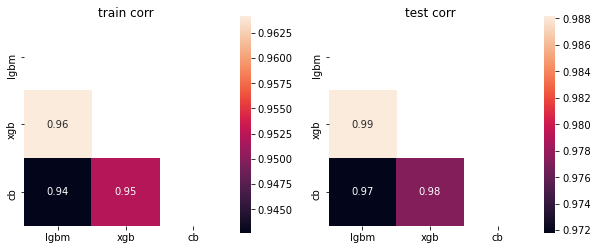

In [15]:
cb_test_preds = cross_valid_prediction(test.drop(trash_features, axis=1), cb_models)

oof_scores, oof_corr_train, mask_train = get_corr({'lgbm': lgbm_oof_preds, 'xgb': xgb_oof_preds, 'cb': cb_oof_preds})
scores, corr_test, mask_test = get_corr({'lgbm': lgbm_test_preds, 'xgb': xgb_test_preds, 'cb': cb_test_preds})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('train corr')
sns.heatmap(oof_corr_train, mask=mask_train, annot=True, square=True, ax=ax[0])

ax[1].set_title('test corr')
sns.heatmap(corr_test, mask=mask_test, annot=True, square=True, ax=ax[1])

# Выполнить задание 2 для трех моделей.

In [16]:
ag_means(oof_scores)

Arithmetic mean: 0.7139962450130497
Geometric mean: 0.7139101687195315
Arithmetic rank mean: 0.7136322856149723
Geometric rank mean: 0.713616152279899


## Вывод:
- В данном случаем арифметическое усреднение результатов покзало лучший результат